<a href="https://colab.research.google.com/github/Deok97/Multi-object-Classification/blob/main/Multi_label_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem to solve: Multi-label Image Classification  
[참고 사이트](https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/)

In [1]:
%matplotlib inline

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as K
from tensorflow.keras.losses import MSE, CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_crossentropy

from keras.datasets import mnist
import matplotlib.pyplot as plt
from google.colab import drive
import imageio
import glob
import cv2 as cv
import imutils

from random import Random
from sklearn.model_selection import train_test_split

### Connection with Google Drive for sample video data  

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# handgun dataset preparation from [DaSCI's Github](https://github.com/ari-dasci/OD-WeaponDetection/tree/master/Pistol%20classification)  
### git clone certain directory: https://webnautes.tistory.com/1387 

In [4]:
%mkdir dataset
%cd dataset
!git init
!git config core.sparsecheckout true
!git remote add -f origin https://github.com/ari-dasci/OD-WeaponDetection.git

# git clone Pistol dataset
!echo 'Pistol classification/AAAPistol' > .git/info/sparse-checkout
!git pull origin master

/content/dataset
Initialized empty Git repository in /content/dataset/.git/
Updating origin
remote: Enumerating objects: 50755, done.
remote: Counting objects: 100% (11673/11673), done.
remote: Compressing objects: 100% (10242/10242), done.
remote: Total 50755 (delta 12), reused 11652 (delta 1), pack-reused 39082
Receiving objects: 100% (50755/50755), 2.26 GiB | 35.37 MiB/s, done.
Resolving deltas: 100% (10979/10979), done.
From https://github.com/ari-dasci/OD-WeaponDetection
 * [new branch]        main       -> origin/main
 * [new branch]        master     -> origin/master
From https://github.com/ari-dasci/OD-WeaponDetection
 * branch              master     -> FETCH_HEAD


### git 초기화 & 다시 git clone

In [5]:
# initialize branch
%rm -r .git
!git init
!git config core.sparsecheckout true
!git remote add -f origin https://github.com/ari-dasci/OD-WeaponDetection.git

# git clone Knife dataset
!echo 'Knife classification/AAAKnife' > .git/info/sparse-checkout
!git pull origin master

Initialized empty Git repository in /content/dataset/.git/
Updating origin
remote: Enumerating objects: 50755, done.
remote: Counting objects: 100% (11673/11673), done.
remote: Compressing objects: 100% (10242/10242), done.
remote: Total 50755 (delta 12), reused 11652 (delta 1), pack-reused 39082
Receiving objects: 100% (50755/50755), 2.26 GiB | 32.80 MiB/s, done.
Resolving deltas: 100% (10979/10979), done.
From https://github.com/ari-dasci/OD-WeaponDetection
 * [new branch]        main       -> origin/main
 * [new branch]        master     -> origin/master
From https://github.com/ari-dasci/OD-WeaponDetection
 * branch              master     -> FETCH_HEAD


# Preprocessing

### Define helper preprocessing function

In [6]:
"""
Description
    shape: image shape to deserve
    dirPath: directory path to image directory
    cls_arr:
      shape: (1, N)
      N: N개의 클래스

    return: (image dataset, class of image dataset)
"""
def prepData(shape: tuple, dirPath: str, cls_arr: np.ndarray):
  dataset = np.zeros(shape)
  for im_path in glob.glob(dirPath):
    im = cv.imread(im_path, cv.IMREAD_COLOR)
    if im.ndim == 3:
      if im.shape[2] == 3:
        im = cv.resize(im, dsize=(231, 231))
        im = im.reshape(1, 231, 231, 3)
        dataset = np.append(dataset, im, axis=0)
  dataset = dataset[1:]
  dataset = dataset.astype('uint8')

  # Image 별로 클래스 나누기
  # dataset_class = [[1., 0.]]
  dataset_class = cls_arr
  dataset_class = np.repeat(dataset_class, repeats=dataset.shape[0], axis=0)
  dataset_class = dataset_class.reshape(-1, 1, 1, 2)

  return dataset, dataset_class



In [7]:
shape = (1, 231, 231, 3)
dirPath = '/content/dataset/Pistol classification/AAAPistol/*.jpg'
cls_arr = [[1., 0.]]
pistol_data, pistol_cls = prepData(shape, dirPath, cls_arr)

In [8]:
shape = (1, 231, 231, 3)
dirPath = '/content/dataset/Knife classification/AAAKnife/*.jpg'
cls_arr = [[0., 1.]]
knife_data, knife_cls = prepData(shape, dirPath, cls_arr)

### Plotting sample images  

((784, 231, 231, 3), (784, 1, 1, 2))

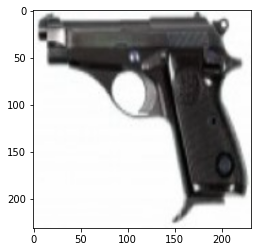

In [9]:
plt.imshow(pistol_data[0])
pistol_data.shape, pistol_cls.shape

((635, 231, 231, 3), (635, 1, 1, 2))

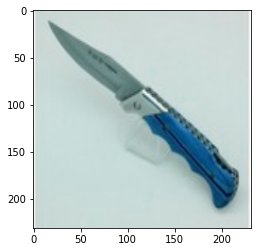

In [10]:
plt.imshow(knife_data[0])
knife_data.shape, knife_cls.shape

### Merge data

### Split & Merge & [Random Shuffle(with seed)](https://stackoverflow.com/questions/19306976/python-shuffling-with-a-parameter-to-get-the-same-result) data  

In [11]:
# 데이터셋을 merge하고 취중되게 split 하게되면, 특정 클래스에 과적합된다
# 7:3 split
pistol_train_X, pistol_test_X, pistol_train_y, pistol_test_y = train_test_split(
    pistol_data, pistol_cls, test_size=0.3, random_state=42)

knife_train_X, knife_test_X, knife_train_y, knife_test_y = train_test_split(
    knife_data, knife_cls, test_size=0.3, random_state=42)

train_X = np.concatenate([pistol_train_X, knife_train_X], axis=0)
train_y = np.concatenate([pistol_train_y, knife_train_y], axis=0)
test_X = np.concatenate([pistol_test_X, knife_test_X], axis=0)
test_y = np.concatenate([pistol_test_y, knife_test_y], axis=0)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((992, 231, 231, 3), (992, 1, 1, 2), (427, 231, 231, 3), (427, 1, 1, 2))

# Overfeat Model Design from Fast Classification
출처: https://arxiv.org/abs/1312.6229  
The main difference with the localization task, is the necessity to predict a background class when no object is present


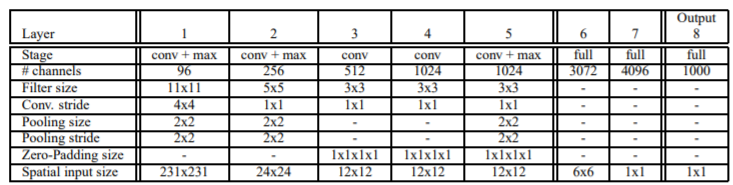

In [46]:
K.clear_session()

# Overfeat 논문에서는 FC Layer을 Convolutional Layer로 변환
# Fully Convolutional Network을 구축
# Our model uses the same fixed input size approach proposed by Krizhevsky et al(AlexNet)
# -> (231, 231)

# input layer
input_ = Input(shape=(231, 231, 3))

# Backbone - 1st layer
# The weights in the network are initialized randomly with (µ, σ) = (0, 1 × 10−2) -> kernel_initializer=RandomNormal(0, 0.01)
# ℓ2 weight decay of 0.00001 -> kernel_regularizer=l2(0.00001)
conv_0 = Conv2D(filters=96, kernel_size=(11, 11), padding='valid', strides=4, activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(input_)
max_0 = MaxPooling2D(pool_size=2, strides=2)(conv_0)

# Backbone - 2nd layer
conv_1 = Conv2D(filters=256, kernel_size = 5, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_0)
max_1 = MaxPooling2D(pool_size=2, strides=2)(conv_1)

# Backbone - 3rd layer
conv_2 = Conv2D(filters = 512, kernel_size=3, strides = 1, padding='same', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_1)

# Backbone - 4th layer
conv_3 = Conv2D(filters = 1024, kernel_size=3, strides = 1, padding='same', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_2)

# Backbone - 5th layer
conv_4 = Conv2D(filters=1024, kernel_size = 3, strides=1, padding='same', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_3)
max_2 = MaxPooling2D(pool_size=2, strides=2)(conv_4)


In [54]:
# Classification - header 1
conv_5 = Conv2D(filters=3072, kernel_size = 6, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_2)

# Classification - header 2
conv_6 = Conv2D(filters=4096, kernel_size = 1, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_5)

# Classification - header 3; output layer
output_ = Conv2D(filters=2, kernel_size = 1, strides=1, padding='valid', activation='sigmoid')(conv_6)

## 모델 컴파일

In [60]:
model = Model(input_, output_)

# Adam implicitly performs coordinate-wise gradient clipping
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

"""
반영 안된 사항
  - The learning rate is successively decreased by a factor of 0.5 after (30, 50, 60, 70, 80) epochs -> learning rate scheduler
  - We extract 5 random crops (and their horizontal flips) of size 221x221 pixels
  - We present these(pixels) to the network n mini-batches of size 128
  - DropOut with a rate of 0.5 is employed on the fully connected layers (6th and 7th) in the classifier
    -> DropOut은 Fully Connected Layers을 Convolutional Layers로 변경하면서 적용 효과가 달라지게 됨.
"""

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 231, 231, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 512)       1180

'\n반영 안된 사항\n  - The learning rate is successively decreased by a factor of 0.5 after (30, 50, 60, 70, 80) epochs -> learning rate scheduler\n  - We extract 5 random crops (and their horizontal flips) of size 221x221 pixels\n  - We present these(pixels) to the network n mini-batches of size 128\n  - DropOut with a rate of 0.5 is employed on the fully connected layers (6th and 7th) in the classifier\n    -> DropOut은 Fully Connected Layers을 Convolutional Layers로 변경하면서 적용 효과가 달라지게 됨.\n'

## 모델 학습

In [61]:
history = model.fit(train_X, train_y, validation_data= (test_X, test_y), batch_size=64, epochs=50)

Epoch 1/50
16/16 [==============================] - 10s 539ms/step - loss: 2.0327 - accuracy: 0.7863 - val_loss: 0.4197 - val_accuracy: 0.8923
Epoch 2/50
16/16 [==============================] - 8s 520ms/step - loss: 0.3866 - accuracy: 0.8952 - val_loss: 0.2678 - val_accuracy: 0.8923
Epoch 3/50
16/16 [==============================] - 8s 523ms/step - loss: 0.2699 - accuracy: 0.8468 - val_loss: 0.3130 - val_accuracy: 0.8923
Epoch 4/50
16/16 [==============================] - 8s 526ms/step - loss: 0.2240 - accuracy: 0.8972 - val_loss: 0.1668 - val_accuracy: 0.9532
Epoch 5/50
16/16 [==============================] - 8s 527ms/step - loss: 0.1675 - accuracy: 0.9274 - val_loss: 0.2895 - val_accuracy: 0.8173
Epoch 6/50
16/16 [==============================] - 8s 529ms/step - loss: 0.2770 - accuracy: 0.9012 - val_loss: 0.3779 - val_accuracy: 0.8571
Epoch 7/50
16/16 [==============================] - 9s 543ms/step - loss: 1.6407 - accuracy: 0.8488 - val_loss: 0.3121 - val_accuracy: 0.8923
Epoch

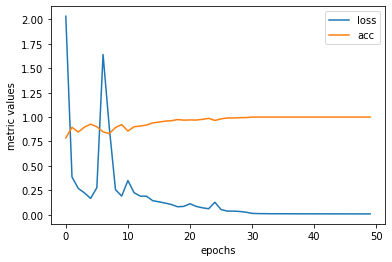

In [63]:
loss = history.history['loss']
acc = history.history['accuracy']

plt.plot(loss)
plt.plot(acc)
plt.xlabel('epochs')
plt.ylabel('metric values')
plt.legend(['loss', 'acc'])
plt.show()

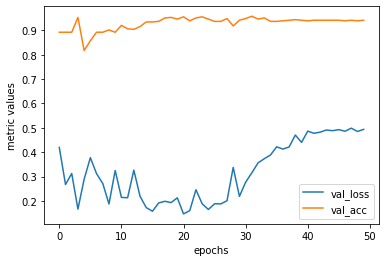

In [68]:
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plt.plot(val_loss)
plt.plot(val_acc)
plt.xlabel('epochs')
plt.ylabel('metric values')
plt.legend(['val_loss', 'val_acc'])
plt.show()

## Visualization

In [69]:
# 지수(Scientific) format -> float format
np.set_printoptions(precision=6, suppress=True)

In [70]:
# 여러개의 이미지에 대한 통합 결과를 보여주는 배열
# indexArray: 여러개의 index값을 갖는 배열
def showResults(indexArray):
  for index in indexArray:
    img_ = test_X[index]
    img = img_.reshape(1, 231, 231, 3)
    pred = model.predict(img)

    plt.imshow(img_)
    plt.title('true: {} | pred: {}'.format(test_y[index].reshape(-1), pred.reshape(-1)))
    plt.show()

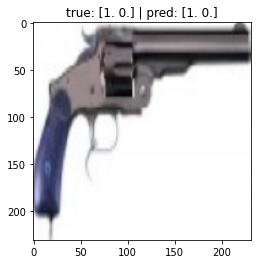

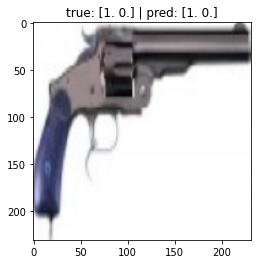

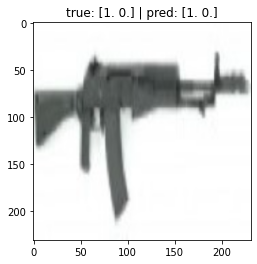

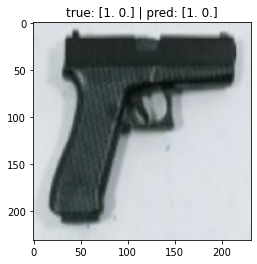

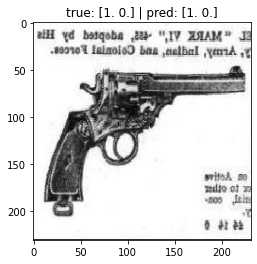

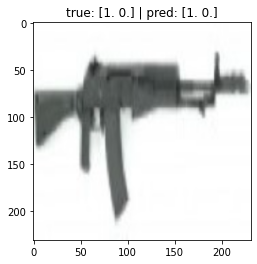

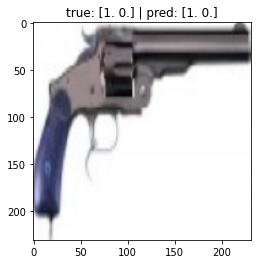

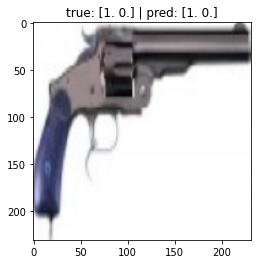

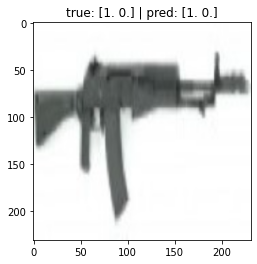

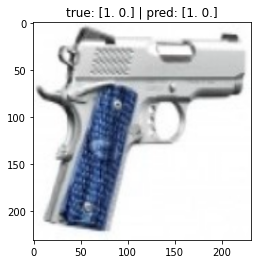

In [71]:
indexArray = range(0, 10)
showResults(indexArray)

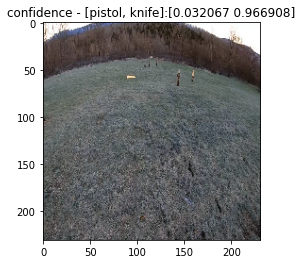

confidence sum aggregation: 0.9989755153656006


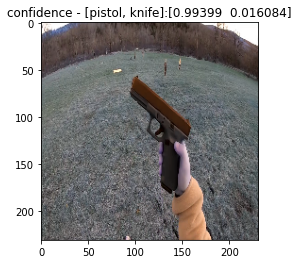

confidence sum aggregation: 1.0100746154785156


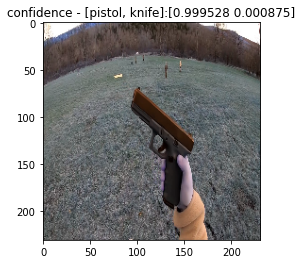

confidence sum aggregation: 1.0004029273986816


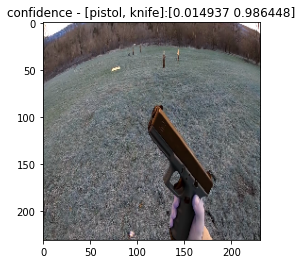

confidence sum aggregation: 1.0013844966888428


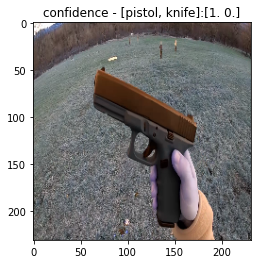

confidence sum aggregation: 1.0


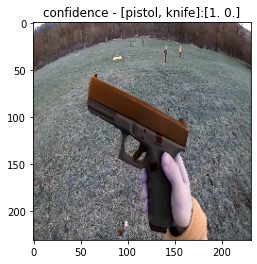

confidence sum aggregation: 1.0


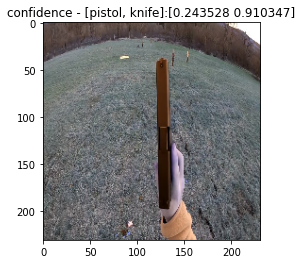

confidence sum aggregation: 1.153875708580017


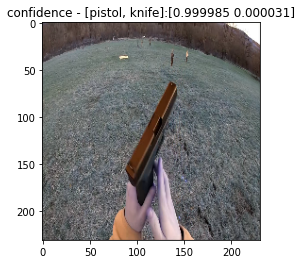

confidence sum aggregation: 1.000015377998352


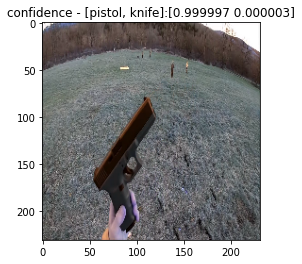

confidence sum aggregation: 1.0000005960464478


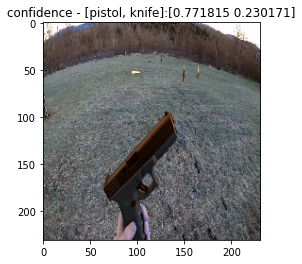

confidence sum aggregation: 1.0019859075546265


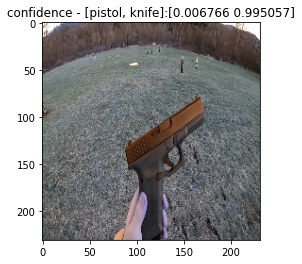

confidence sum aggregation: 1.001822590827942


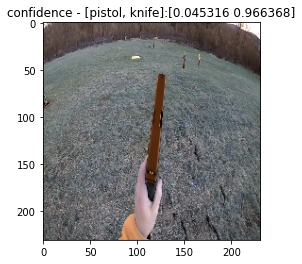

confidence sum aggregation: 1.0116833448410034


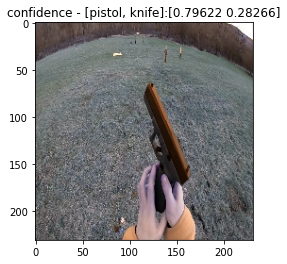

confidence sum aggregation: 1.078879475593567


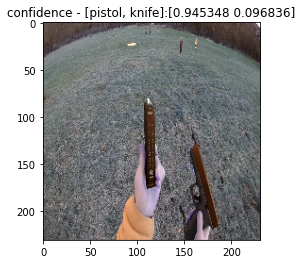

confidence sum aggregation: 1.0421841144561768


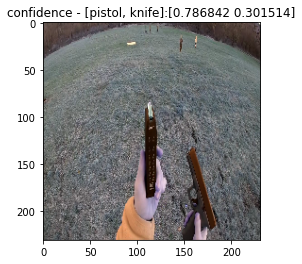

confidence sum aggregation: 1.088356375694275


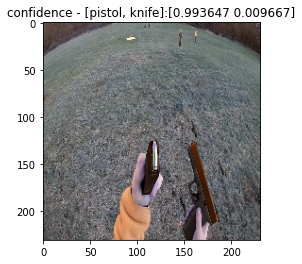

confidence sum aggregation: 1.0033141374588013


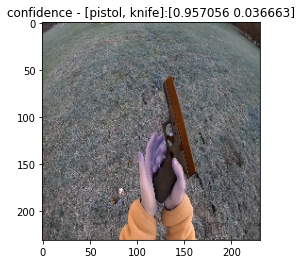

confidence sum aggregation: 0.993719220161438


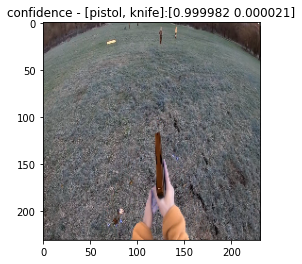

confidence sum aggregation: 1.0000033378601074


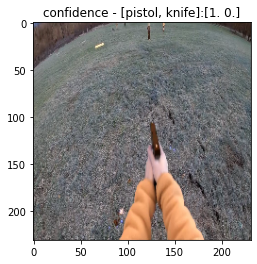

confidence sum aggregation: 1.0


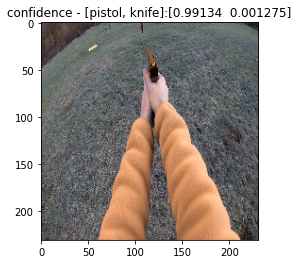

confidence sum aggregation: 0.9926151633262634


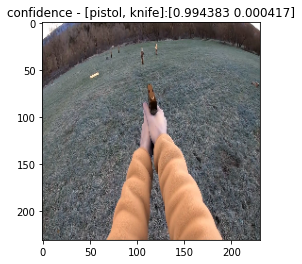

confidence sum aggregation: 0.9947999119758606


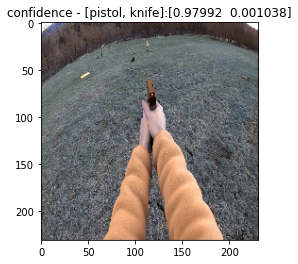

confidence sum aggregation: 0.9809576272964478


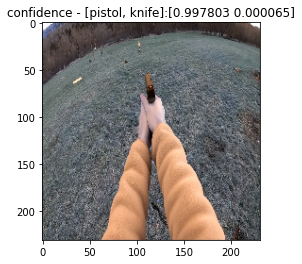

confidence sum aggregation: 0.9978679418563843


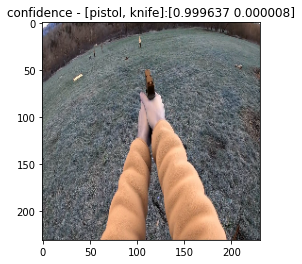

confidence sum aggregation: 0.999644935131073


KeyboardInterrupt: ignored

In [73]:
cap = cv.VideoCapture('/content/gdrive/MyDrive/sample/pistol_sample.mp4')

i=0
period = 50
if not cap.isOpened():
  print('cannot open video')
  exit()

while True:
  ret, frame = cap.read()
  if ret is None:
    print('=================== End of video stream ===================')
    break
  if i%period == 0:
    frame_ = cv.resize(frame, (231, 231))
    frame = frame_.reshape(1, 231, 231, 3)
    pred = model.predict(frame)

    plt.imshow(frame_)
    plt.title('confidence - [pistol, knife]:{}'.format(pred.reshape(-1)))
    plt.show()

    print('confidence sum aggregation: {}'.format(pred.sum()))
  i +=1
  


# To Do  
- 왜 softmax -> sigmoid로 변경해도 모델의 출력 값의 합이 1에 가까운가?  
- 어째서 배경을 보고 knife라고 분류하는가?  